# Simulation Study

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rcParams

%matplotlib inline
sns.set_theme()

torch.manual_seed(42)
np.random.seed(123)

os.environ['CUDA_VISIBLE_DEVICES'] = '9'

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [2]:
from src.model import EnergyTDContinuous


class Trainer:
    """docstring for Trainer."""
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        epoch=500,
        eval_interval=10,
        print_eval=True
    ):
        super(Trainer, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epoch = epoch

        self.eval_interval = eval_interval
        self.print_eval = print_eval

        self.current_epoch = 0
        self.loss_log = {'train': [], 'test': [], 'val': []}

    def train(self, train_loader, valid_loader=None, test_loader=None):
        bar = tqdm(range(self.epoch), desc='[Epoch 0]')
        for epoch in bar:
            bar.set_description(f'[Epoch {epoch}]')
            self.train_epoch(train_loader)
            if valid_loader is not None:
                self.eval_epoch(valid_loader, 'Valid')
            if test_loader is not None:
                self.eval_epoch(test_loader, 'Test')
            self.current_epoch += 1
            self.scheduler.step()

            bar.set_postfix({'Loss': self.current_loss})

    def train_epoch(self, data_loader):
        model = self.model

        model.train()

        loss_log = []
        for batch_idx, (inputs, x_val) in enumerate(data_loader):
            inputs = inputs.to(DEVICE)
            x_val = x_val.to(DEVICE)

            try:
                vnce = model.loss(inputs, x_val)
            except:
                vnce = model(inputs, x_val, sample=True)
            loss = - vnce

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            loss_log.append(vnce.item())

        loss_log = np.mean(loss_log)
        self.current_loss = loss_log
        self.loss_log['train'].append(loss_log)

torch.Size([8, 8, 200])


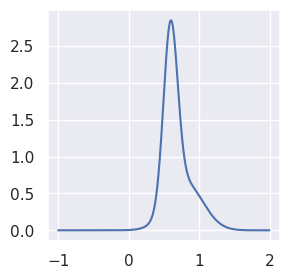

In [3]:
R = 5
I = [8] * 2
N = 200
BATCH_SIZE = 1000
GRID = 1e-3

factors = []
for i in I:
    # factors.append(torch.rand(i, R) * torch.pi * 0.5)
    factors.append(torch.rand(i, R))

tensor_ = torch.einsum('ia, ja-> ij', *factors)
tensor_ /= tensor_.abs().max()

tensor = []
# SIG1 = 1.
# SIG2 = 1.5
SIG1 = 0.1
SIG2 = 0.25
RATE1 = 0.4
for n in range(N):
    # mixture1 = torch.randn_like(tensor_) * SIG1 + 2. + tensor_
    # mixture2 = torch.randn_like(tensor_) * SIG2 - 2. + tensor_
    mixture1 = torch.randn_like(tensor_) * SIG1 + tensor_.cos()
    mixture2 = torch.randn_like(tensor_) * SIG2 + tensor_.sin()
    if np.random.rand() > RATE1:
        tensor.append(mixture1)
    else:
        tensor.append(mixture2)
tensor = torch.stack(tensor, -1)
# tensor /= 5.
print(tensor.shape)

x_bound = [-1., 2.]
x_range = torch.arange(*x_bound, step=GRID).numpy()
# true_pdf = (1 - RATE1) * norm.pdf(x_range, tensor_[0, 0] + 2., SIG1) + \
#     RATE1 * norm.pdf(x_range, tensor_[0, 0] - 2., SIG2)
true_pdf = (1 - RATE1) * norm.pdf(x_range, tensor_[0, 0].cos(), SIG1) + \
    RATE1 * norm.pdf(x_range, tensor_[0, 0].sin(), SIG2)

plt.figure(figsize=(3, 3))
plt.plot(x_range, true_pdf)

In [4]:
train_idx = torch.nonzero(torch.ones_like(tensor), as_tuple=True)
train_val = tensor[train_idx]
train_idx = torch.stack(train_idx).T
train_idx = train_idx[:, :2]
train_dt = TensorDataset(train_idx, train_val)
train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True)
print(train_dt.tensors[0].shape)

torch.Size([12800, 2])


In [5]:
RANK = 3
H_DIM = [64] * 5
ACT = 'elu'
NOISE_SIGMA = 0.3
NU = 10

EPOCH = 500
LR = 1e-3

model = EnergyTDContinuous(
    tensor_shape=I,
    rank=RANK,
    h_dim=H_DIM,
    act=ACT,
    noise_sigma=NOISE_SIGMA,
    embedding_size=1,
    nu=NU,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
miles = [int(i * EPOCH) for i in (0.6, 0.75, 0.9)]
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer, milestones=miles, gamma=0.3,
)
trainer = Trainer(
    model=model, optimizer=optimizer, scheduler=scheduler, epoch=EPOCH
)
trainer.train(train_loader)

[Epoch 0]:   0%|          | 0/500 [00:00<?, ?it/s]

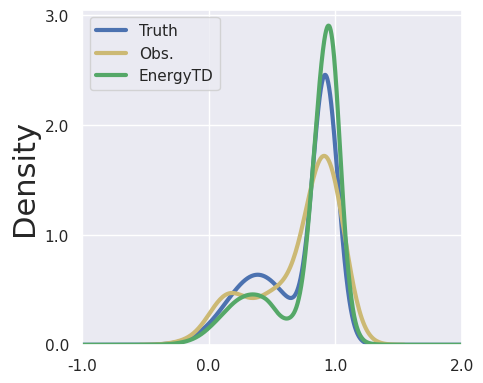

In [7]:
GRID = 1e-3
IDX1 = 5
IDX2 = 3

model = trainer.model
model.train()
# gp_model = gp_trainer.model
# gp_model.train()

plt.figure(figsize=(5, 4))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']

x_bound = [-1., 2.]
x_range = torch.arange(*x_bound, step=GRID).numpy()
true_pdf = (1 - RATE1) * norm.pdf(x_range, tensor_[IDX1, IDX2].cos(), SIG1) + \
    RATE1 * norm.pdf(x_range, tensor_[IDX1, IDX2].sin(), SIG2)

plt.plot(x_range, true_pdf, color='b', label='Truth', linewidth=3)

# GP
# idx = torch.tensor(
#     [IDX1, IDX2], dtype=torch.int64, device=DEVICE
# ).view(1, -1)
# x_mean_hat = gp_model(idx, predict=True)
# gp_est_pdf = norm.pdf(x_range, x_mean_hat.detach().cpu(), NOISE_SIGMA)

# energy TD
x_range = torch.arange(*x_bound, step=GRID).to(DEVICE)
idx = torch.tensor(
    [IDX1, IDX2], dtype=torch.int64, device=DEVICE
).view(1, -1).repeat(len(x_range), 1)
u_log_prob = model(idx, x_range, sample=False, return_z=False)
prob = u_log_prob.exp().detach().cpu().numpy()
partition = (prob * GRID).sum()
prob = prob / partition

sns.kdeplot(tensor[IDX1, IDX2, :], color='y', label='Obs.', linewidth=3)
# plt.plot(x_range.cpu().numpy(), gp_est_pdf, color='r', alpha=1, label='GPTF', linewidth=3)
plt.plot(x_range.cpu().numpy(), prob, color='g', alpha=1, label='EnergyTD', linewidth=3)
plt.xlim(x_bound)


plt.ylabel('Density', fontsize=22)

plt.xlim([-1, 2])
plt.yticks([0.0, 1.0, 2.0, 3.0])
plt.xticks([-1.0, 0.0, 1.0, 2.0])
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig('simu_mog.pdf', format="pdf", bbox_inches="tight")